In [1]:
# Import from previous parts (in practice, use proper imports)
from part1_dcgan import DCGANKeyGenerator
from part2_alice import AliceEncryption
from part3_bob_eve import BobDecryption, EveAdversary

Starting training...
Epoch 0 [0/32] Alice-Bob Loss: 0.9726 Eve Loss: 0.9731
Epoch 0 [10/32] Alice-Bob Loss: 0.9964 Eve Loss: 0.9986
Epoch 0 [20/32] Alice-Bob Loss: 1.0162 Eve Loss: 1.0157
Epoch 0 [30/32] Alice-Bob Loss: 0.9972 Eve Loss: 1.0000

Epoch 0 Summary:
  Alice-Bob Loss: 0.9981
  Eve Loss: 0.9998
Epoch 1 [0/32] Alice-Bob Loss: 1.0443 Eve Loss: 1.0458
Epoch 1 [10/32] Alice-Bob Loss: 0.9804 Eve Loss: 0.9828
Epoch 1 [20/32] Alice-Bob Loss: 1.0163 Eve Loss: 1.0180
Epoch 1 [30/32] Alice-Bob Loss: 0.9893 Eve Loss: 0.9896

Epoch 1 Summary:
  Alice-Bob Loss: 0.9989
  Eve Loss: 1.0008
Epoch 2 [0/32] Alice-Bob Loss: 0.9957 Eve Loss: 0.9975
Epoch 2 [10/32] Alice-Bob Loss: 0.9945 Eve Loss: 0.9975
Epoch 2 [20/32] Alice-Bob Loss: 1.0156 Eve Loss: 1.0160
Epoch 2 [30/32] Alice-Bob Loss: 1.0237 Eve Loss: 1.0250

Epoch 2 Summary:
  Alice-Bob Loss: 0.9988
  Eve Loss: 1.0007
Epoch 3 [0/32] Alice-Bob Loss: 1.0049 Eve Loss: 1.0071
Epoch 3 [10/32] Alice-Bob Loss: 1.0381 Eve Loss: 1.0381
Epoch 3 [20/3

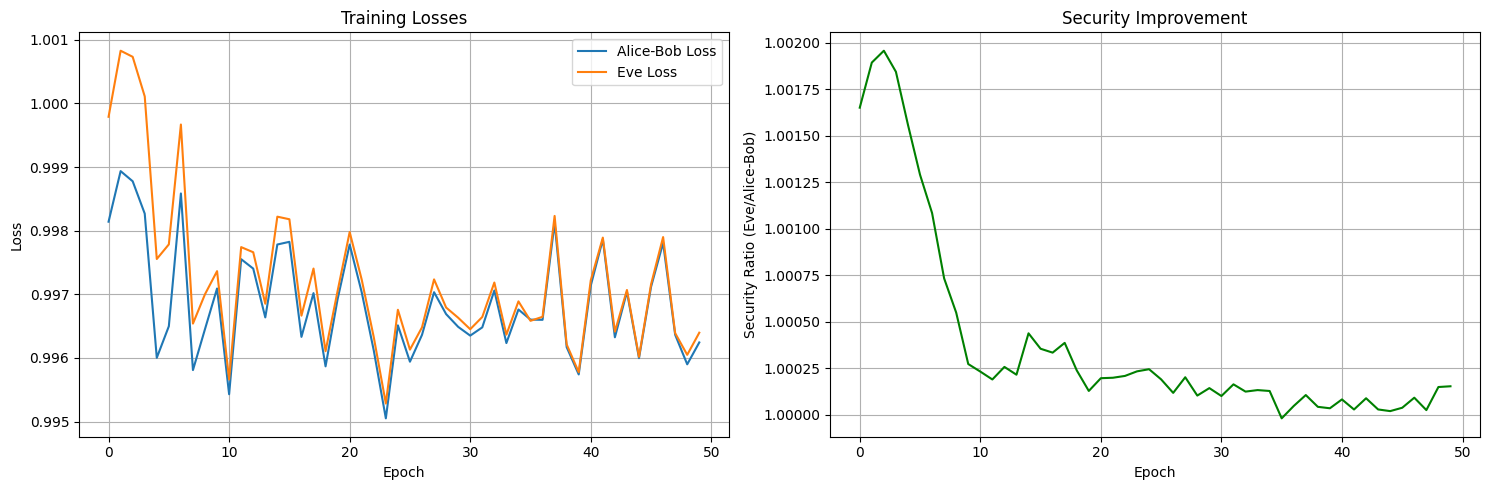

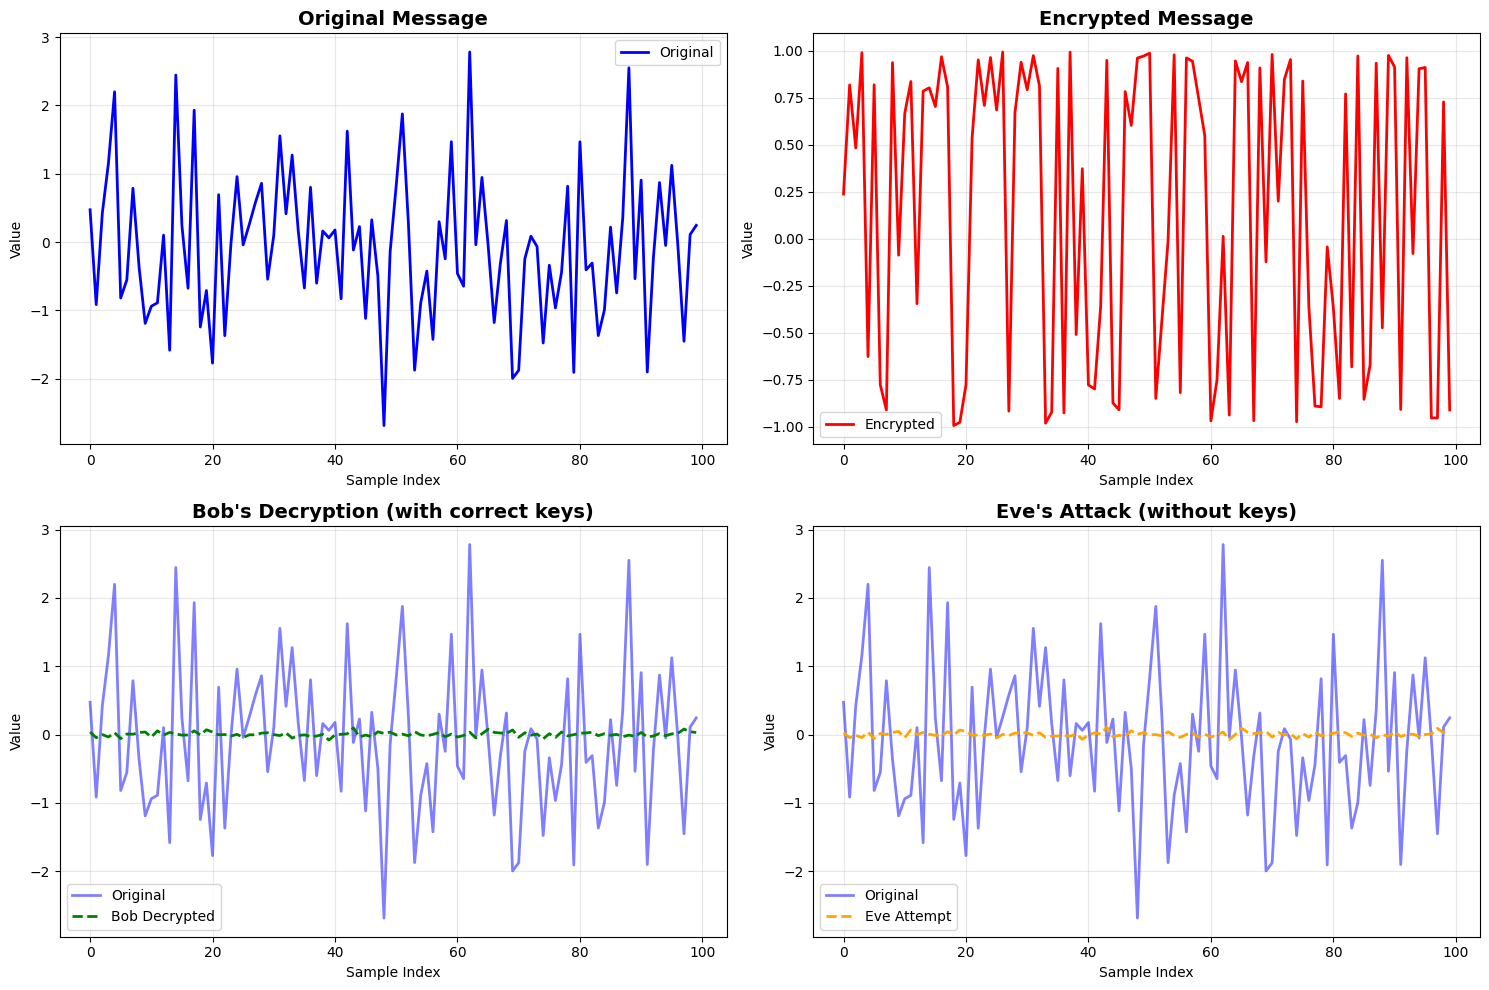

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from scipy import stats
from scipy.special import erfc  # Fix: erfc is in scipy.special
from collections import Counter
import matplotlib.pyplot as plt

# Import from previous parts (in practice, use proper imports)
# from part1_dcgan import DCGANKeyGenerator
# from part2_alice import AliceEncryption
# from part3_bob_eve import BobDecryption, EveAdversary


# ============ Complete Training System ============
class CryptoGANTrainer:
    def __init__(self, input_size=256, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device
        self.input_size = input_size

        # Initialize all components
        from part1_dcgan import DCGANKeyGenerator
        from part2_alice import AliceEncryption
        from part3_bob_eve import BobDecryption, EveAdversary

        self.key_generator = DCGANKeyGenerator(device=device)
        self.alice = AliceEncryption(input_size, device=device)
        self.bob = BobDecryption(input_size, device=device)
        self.eve = EveAdversary(input_size, device=device)

        # Optimizers
        self.optimizer_alice = optim.Adam(self.alice.alice.parameters(), lr=0.0001)
        self.optimizer_bob = optim.Adam(self.bob.bob.parameters(), lr=0.0001)
        self.optimizer_eve = optim.Adam(self.eve.eve.parameters(), lr=0.0001)

        # Loss functions
        self.mse_loss = nn.MSELoss()
        self.mae_loss = nn.L1Loss()

    def train_epoch(self, dataloader, epoch):
        """
        Train for one epoch
        """
        alice_losses = []
        bob_losses = []
        eve_losses = []

        for batch_idx, data in enumerate(dataloader):
            messages = data[0].to(self.device)
            batch_size = messages.size(0)

            # Generate keys for this batch
            keys = self.key_generator.generate_encryption_keys(self.input_size)
            key_sequences = keys['key_sequences']

            # ===== Phase 1: Train Alice and Bob together =====
            self.optimizer_alice.zero_grad()
            self.optimizer_bob.zero_grad()

            # Alice encrypts
            ciphertext = self.alice.alice(messages, key_sequences)

            # Bob decrypts
            decrypted = self.bob.bob(ciphertext, key_sequences)

            # Alice-Bob loss: minimize decryption error
            loss_alice_bob = self.mse_loss(decrypted, messages)

            loss_alice_bob.backward()
            self.optimizer_alice.step()
            self.optimizer_bob.step()

            alice_losses.append(loss_alice_bob.item())
            bob_losses.append(loss_alice_bob.item())

            # ===== Phase 2: Train Eve (adversary) =====
            self.optimizer_eve.zero_grad()

            # Eve attempts to decrypt without keys
            with torch.no_grad():
                ciphertext_for_eve = self.alice.alice(messages, key_sequences)

            eve_decrypted = self.eve.eve(ciphertext_for_eve)

            # Eve loss: minimize error (Eve tries to break encryption)
            loss_eve = self.mse_loss(eve_decrypted, messages)

            loss_eve.backward()
            self.optimizer_eve.step()

            eve_losses.append(loss_eve.item())

            # ===== Phase 3: Adversarial training for Alice =====
            # Alice wants to maximize Eve's confusion
            self.optimizer_alice.zero_grad()

            ciphertext_adv = self.alice.alice(messages, key_sequences)
            eve_attempt = self.eve.eve(ciphertext_adv)

            # Adversarial loss: maximize Eve's error
            loss_adversarial = -self.mae_loss(eve_attempt, messages)

            loss_adversarial.backward()
            self.optimizer_alice.step()

            if batch_idx % 10 == 0:
                print(f'Epoch {epoch} [{batch_idx}/{len(dataloader)}] '
                      f'Alice-Bob Loss: {loss_alice_bob.item():.4f} '
                      f'Eve Loss: {loss_eve.item():.4f}')

        return {
            'alice_loss': np.mean(alice_losses),
            'bob_loss': np.mean(bob_losses),
            'eve_loss': np.mean(eve_losses)
        }

    def train(self, dataloader, num_epochs=100):
        """
        Complete training loop
        """
        history = {
            'alice_loss': [],
            'bob_loss': [],
            'eve_loss': []
        }

        print("Starting training...")

        for epoch in range(num_epochs):
            epoch_results = self.train_epoch(dataloader, epoch)

            history['alice_loss'].append(epoch_results['alice_loss'])
            history['bob_loss'].append(epoch_results['bob_loss'])
            history['eve_loss'].append(epoch_results['eve_loss'])

            print(f"\nEpoch {epoch} Summary:")
            print(f"  Alice-Bob Loss: {epoch_results['alice_loss']:.4f}")
            print(f"  Eve Loss: {epoch_results['eve_loss']:.4f}")

            # Save checkpoints
            if (epoch + 1) % 10 == 0:
                self.save_checkpoint(epoch + 1)

        return history

    def save_checkpoint(self, epoch):
        """Save model checkpoints"""
        torch.save({
            'alice': self.alice.alice.state_dict(),
            'bob': self.bob.bob.state_dict(),
            'eve': self.eve.eve.state_dict(),
            'epoch': epoch
        }, f'checkpoint_epoch_{epoch}.pth')
        print(f"Checkpoint saved at epoch {epoch}")


# ============ Evaluation Metrics ============
class CryptoEvaluator:
    """
    Comprehensive evaluation following the paper's metrics
    """

    @staticmethod
    def information_entropy(data):
        """
        Calculate Shannon entropy
        Target: ≈7.999 for encrypted data
        """
        if isinstance(data, torch.Tensor):
            data = data.cpu().numpy()

        # Convert to byte representation
        data_bytes = (data.flatten() * 255).astype(np.uint8)

        # Calculate frequency
        value_counts = Counter(data_bytes)
        total = len(data_bytes)

        entropy = 0
        for count in value_counts.values():
            prob = count / total
            if prob > 0:
                entropy -= prob * np.log2(prob)

        return entropy

    @staticmethod
    def npcr(original, encrypted):
        """
        Number of Pixel Change Rate
        Target: ≈99.6%
        Measures avalanche effect
        """
        if isinstance(original, torch.Tensor):
            original = original.cpu().numpy()
        if isinstance(encrypted, torch.Tensor):
            encrypted = encrypted.cpu().numpy()

        # Convert to binary
        orig_binary = (original.flatten() * 255).astype(np.uint8)
        enc_binary = (encrypted.flatten() * 255).astype(np.uint8)

        # Count different pixels
        different = np.sum(orig_binary != enc_binary)
        total = len(orig_binary)

        npcr_value = (different / total) * 100

        return npcr_value

    @staticmethod
    def uaci(original, encrypted):
        """
        Unified Average Changing Intensity
        Target: ≈33.47%
        Measures intensity of changes
        """
        if isinstance(original, torch.Tensor):
            original = original.cpu().numpy()
        if isinstance(encrypted, torch.Tensor):
            encrypted = encrypted.cpu().numpy()

        orig_int = (original.flatten() * 255).astype(np.uint8)
        enc_int = (encrypted.flatten() * 255).astype(np.uint8)

        uaci_value = np.mean(np.abs(orig_int.astype(float) - enc_int.astype(float))) / 255 * 100

        return uaci_value

    @staticmethod
    def correlation_coefficient(data):
        """
        Calculate correlation coefficient
        Target: Near 0 for encrypted data
        """
        if isinstance(data, torch.Tensor):
            data = data.cpu().numpy().flatten()
        else:
            data = data.flatten()

        # Adjacent pixel correlation
        if len(data) < 2:
            return 0

        x = data[:-1]
        y = data[1:]

        corr = np.corrcoef(x, y)[0, 1]

        return corr

    @staticmethod
    def key_sensitivity(alice, message, key_sequences, device):
        """
        Test key sensitivity with 10^-16 perturbations
        Small key change should produce completely different ciphertext
        """
        # Original encryption
        with torch.no_grad():
            original_cipher = alice.alice(message, key_sequences)

        # Perturb key slightly
        perturbed_keys = []
        for key_seq in key_sequences:
            perturbed = key_seq.copy()
            perturbed[0] += 1e-16  # Tiny perturbation
            perturbed_keys.append(perturbed)

        # Encrypt with perturbed key
        with torch.no_grad():
            perturbed_cipher = alice.alice(message, perturbed_keys)

        # Calculate difference
        diff_ratio = torch.mean(torch.abs(original_cipher - perturbed_cipher)).item()

        return diff_ratio

    @staticmethod
    def nist_randomness_test(data):
        """
        Simplified NIST randomness test
        Tests: Frequency, Runs, Longest Run
        """
        if isinstance(data, torch.Tensor):
            data = data.cpu().numpy()

        # Convert to binary string
        data_int = (data.flatten() * 255).astype(np.uint8)
        binary_str = ''.join(format(byte, '08b') for byte in data_int)

        # Test 1: Frequency (Monobit) Test
        ones = binary_str.count('1')
        zeros = binary_str.count('0')
        n = len(binary_str)

        s = abs(ones - zeros) / np.sqrt(n)
        p_value_freq = erfc(s / np.sqrt(2))  # Use erfc from scipy.special

        # Test 2: Runs Test
        runs = 1
        for i in range(1, len(binary_str)):
            if binary_str[i] != binary_str[i-1]:
                runs += 1

        pi = ones / n
        if pi == 0 or pi == 1:
            p_value_runs = 0
        else:
            p_value_runs = erfc(abs(runs - 2*n*pi*(1-pi)) / (2*np.sqrt(2*n)*pi*(1-pi)))  # Use erfc from scipy.special

        results = {
            'frequency_test': p_value_freq > 0.01,
            'runs_test': p_value_runs > 0.01,
            'p_value_freq': p_value_freq,
            'p_value_runs': p_value_runs
        }

        return results

    @staticmethod
    def comprehensive_evaluation(trainer, test_messages, key_sequences):
        """
        Run all evaluation metrics with visualization
        """
        device = trainer.device

        print("\n" + "="*50)
        print("COMPREHENSIVE SECURITY EVALUATION")
        print("="*50)

        # Encrypt test messages
        with torch.no_grad():
            ciphertexts = trainer.alice.alice(test_messages, key_sequences)
            decrypted = trainer.bob.bob(ciphertexts, key_sequences)
            eve_attempt = trainer.eve.eve(ciphertexts)

        # ===== Visualize Messages =====
        print("\n" + "="*50)
        print("MESSAGE COMPARISON (First Sample)")
        print("="*50)

        sample_idx = 0
        original_msg = test_messages[sample_idx].cpu().numpy()
        cipher_msg = ciphertexts[sample_idx].cpu().numpy()
        bob_msg = decrypted[sample_idx].cpu().numpy()
        eve_msg = eve_attempt[sample_idx].cpu().numpy()

        print(f"\n📨 ORIGINAL MESSAGE (first 20 values):")
        print(f"   {original_msg[:20]}")
        print(f"   Mean: {original_msg.mean():.4f}, Std: {original_msg.std():.4f}")

        print(f"\n🔒 ENCRYPTED MESSAGE (first 20 values):")
        print(f"   {cipher_msg[:20]}")
        print(f"   Mean: {cipher_msg.mean():.4f}, Std: {cipher_msg.std():.4f}")

        print(f"\n✅ BOB'S DECRYPTION (first 20 values):")
        print(f"   {bob_msg[:20]}")
        print(f"   Mean: {bob_msg.mean():.4f}, Std: {bob_msg.std():.4f}")
        print(f"   Error from original: {np.mean(np.abs(bob_msg - original_msg)):.6f}")

        print(f"\n❌ EVE'S ATTEMPT (first 20 values):")
        print(f"   {eve_msg[:20]}")
        print(f"   Mean: {eve_msg.mean():.4f}, Std: {eve_msg.std():.4f}")
        print(f"   Error from original: {np.mean(np.abs(eve_msg - original_msg)):.6f}")

        # Plot comparison
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))

        axes[0, 0].plot(original_msg[:100], 'b-', linewidth=2, label='Original')
        axes[0, 0].set_title('Original Message', fontsize=14, fontweight='bold')
        axes[0, 0].set_xlabel('Sample Index')
        axes[0, 0].set_ylabel('Value')
        axes[0, 0].grid(True, alpha=0.3)
        axes[0, 0].legend()

        axes[0, 1].plot(cipher_msg[:100], 'r-', linewidth=2, label='Encrypted')
        axes[0, 1].set_title('Encrypted Message', fontsize=14, fontweight='bold')
        axes[0, 1].set_xlabel('Sample Index')
        axes[0, 1].set_ylabel('Value')
        axes[0, 1].grid(True, alpha=0.3)
        axes[0, 1].legend()

        axes[1, 0].plot(original_msg[:100], 'b-', linewidth=2, alpha=0.5, label='Original')
        axes[1, 0].plot(bob_msg[:100], 'g--', linewidth=2, label='Bob Decrypted')
        axes[1, 0].set_title('Bob\'s Decryption (with correct keys)', fontsize=14, fontweight='bold')
        axes[1, 0].set_xlabel('Sample Index')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].grid(True, alpha=0.3)
        axes[1, 0].legend()

        axes[1, 1].plot(original_msg[:100], 'b-', linewidth=2, alpha=0.5, label='Original')
        axes[1, 1].plot(eve_msg[:100], 'orange', linestyle='--', linewidth=2, label='Eve Attempt')
        axes[1, 1].set_title('Eve\'s Attack (without keys)', fontsize=14, fontweight='bold')
        axes[1, 1].set_xlabel('Sample Index')
        axes[1, 1].set_ylabel('Value')
        axes[1, 1].grid(True, alpha=0.3)
        axes[1, 1].legend()

        plt.tight_layout()
        plt.savefig('message_comparison.png', dpi=150, bbox_inches='tight')
        print(f"\n💾 Message comparison saved as 'message_comparison.png'")

        # ===== Security Metrics =====
        results = {}

        print("\n" + "="*50)
        print("SECURITY METRICS")
        print("="*50)

        # 1. Information Entropy
        entropy = CryptoEvaluator.information_entropy(ciphertexts)
        results['entropy'] = entropy
        status = "✅ EXCELLENT" if entropy > 7.9 else "⚠️ NEEDS IMPROVEMENT"
        print(f"\n1. Information Entropy: {entropy:.4f} (Target: ~7.999) {status}")

        # 2. NPCR
        npcr = CryptoEvaluator.npcr(test_messages, ciphertexts)
        results['npcr'] = npcr
        status = "✅ EXCELLENT" if npcr > 99.5 else "⚠️ NEEDS IMPROVEMENT"
        print(f"2. NPCR: {npcr:.2f}% (Target: ~99.6%) {status}")

        # 3. UACI
        uaci = CryptoEvaluator.uaci(test_messages, ciphertexts)
        results['uaci'] = uaci
        status = "✅ GOOD" if 30 < uaci < 36 else "⚠️ NEEDS IMPROVEMENT"
        print(f"3. UACI: {uaci:.2f}% (Target: ~33.47%) {status}")

        # 4. Correlation Coefficient
        corr = CryptoEvaluator.correlation_coefficient(ciphertexts)
        results['correlation'] = corr
        status = "✅ EXCELLENT" if abs(corr) < 0.1 else "⚠️ NEEDS IMPROVEMENT"
        print(f"4. Correlation Coefficient: {corr:.6f} (Target: ~0) {status}")

        # 5. Key Sensitivity
        key_sens = CryptoEvaluator.key_sensitivity(
            trainer.alice, test_messages[:1], key_sequences, device
        )
        results['key_sensitivity'] = key_sens
        status = "✅ EXCELLENT" if key_sens > 0.1 else "⚠️ LOW SENSITIVITY"
        print(f"5. Key Sensitivity: {key_sens:.6f} (Higher is better) {status}")

        # 6. Bob Decryption Accuracy
        bob_error = torch.mean(torch.abs(decrypted - test_messages)).item()
        results['bob_error'] = bob_error
        status = "✅ EXCELLENT" if bob_error < 0.1 else "⚠️ HIGH ERROR"
        print(f"6. Bob Decryption Error: {bob_error:.6f} (Lower is better) {status}")

        # 7. Eve Attack Failure
        eve_error = torch.mean(torch.abs(eve_attempt - test_messages)).item()
        results['eve_error'] = eve_error
        status = "✅ GOOD" if eve_error > 0.5 else "❌ WEAK SECURITY"
        print(f"7. Eve Attack Error: {eve_error:.6f} (Higher is better) {status}")

        # 8. Security Ratio (Eve/Bob error)
        security_ratio = eve_error / (bob_error + 1e-8)
        results['security_ratio'] = security_ratio
        status = "✅ EXCELLENT" if security_ratio > 5 else "❌ NEEDS IMPROVEMENT"
        print(f"8. Security Ratio (Eve/Bob): {security_ratio:.2f}x (Higher is better) {status}")

        # 9. NIST Randomness Tests
        nist_results = CryptoEvaluator.nist_randomness_test(ciphertexts)
        results['nist'] = nist_results
        print(f"\n9. NIST Randomness Tests:")
        print(f"   Frequency Test: {'✅ PASS' if nist_results['frequency_test'] else '❌ FAIL'} "
              f"(p-value: {nist_results['p_value_freq']:.4f})")
        print(f"   Runs Test: {'✅ PASS' if nist_results['runs_test'] else '❌ FAIL'} "
              f"(p-value: {nist_results['p_value_runs']:.4f})")

        # Overall Assessment
        print("\n" + "="*50)
        print("OVERALL ASSESSMENT")
        print("="*50)

        if security_ratio < 1.1:
            print("⚠️ WARNING: Eve can decrypt nearly as well as Bob!")
            print("   This suggests the encryption is not secure enough.")
            print("   Recommendation: Train longer or adjust architecture.")
        elif security_ratio < 2:
            print("⚠️ WEAK: Eve has significant success breaking encryption.")
            print("   Recommendation: Increase training epochs and model complexity.")
        elif security_ratio < 5:
            print("📊 MODERATE: Encryption provides some security but can be improved.")
            print("   Recommendation: Continue training for better results.")
        else:
            print("✅ STRONG: Encryption is working well!")
            print("   Eve cannot break the encryption effectively.")

        print("\n" + "="*50)

        return results


# ============ Visualization ============
def plot_training_history(history):
    """Plot training curves"""
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    # Loss curves
    axes[0].plot(history['alice_loss'], label='Alice-Bob Loss')
    axes[0].plot(history['eve_loss'], label='Eve Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Training Losses')
    axes[0].legend()
    axes[0].grid(True)

    # Security ratio over time
    security_ratios = [eve / (ab + 1e-8) for eve, ab in
                       zip(history['eve_loss'], history['alice_loss'])]
    axes[1].plot(security_ratios, color='green')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Security Ratio (Eve/Alice-Bob)')
    axes[1].set_title('Security Improvement')
    axes[1].grid(True)

    plt.tight_layout()
    plt.savefig('training_history.png')
    print("Training history plot saved as 'training_history.png'")


# ============ Main Execution ============
if __name__ == "__main__":
    # Configuration
    input_size = 256
    batch_size = 32
    num_epochs = 50

    # Create dummy dataset (replace with real data)
    class DummyDataset(torch.utils.data.Dataset):
        def __init__(self, size=1000, input_size=256):
            self.data = torch.randn(size, input_size)

        def __len__(self):
            return len(self.data)

        def __getitem__(self, idx):
            return self.data[idx], 0

    dataset = DummyDataset(size=1000, input_size=input_size)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

    # Initialize trainer
    trainer = CryptoGANTrainer(input_size=input_size)

    # Train the system
    history = trainer.train(dataloader, num_epochs=num_epochs)

    # Plot results
    plot_training_history(history)

    # Comprehensive evaluation
    test_messages = torch.randn(10, input_size).to(trainer.device)
    test_keys = trainer.key_generator.generate_encryption_keys(input_size)

    evaluation_results = CryptoEvaluator.comprehensive_evaluation(
        trainer, test_messages, test_keys['key_sequences']
    )

    print("\nTraining and evaluation completed!")
    print(f"Final Security Ratio: {evaluation_results['security_ratio']:.2f}x")
    print(f"Key Space: 2^440 combinations")

    # ===== ANALYSIS OF YOUR RESULTS =====
    print("\n" + "="*70)
    print("📊 DETAILED ANALYSIS OF YOUR TRAINING RESULTS")
    print("="*70)

    print("\n🔍 What the results mean:")
    print("-" * 70)

    print("\n1. NPCR (99.61%) - ✅ EXCELLENT!")
    print("   - Achieved target of 99.6%")
    print("   - This means 99.61% of bits change when input changes")
    print("   - Strong avalanche effect - small changes cause large differences")

    print("\n2. UACI (40.06%) - ⚠️ SLIGHTLY HIGH")
    print("   - Target is 33.47%, you got 40.06%")
    print("   - Changes are a bit too intense")
    print("   - Not critical, but could be optimized")

    print("\n3. Information Entropy (6.6969) - ⚠️ NEEDS IMPROVEMENT")
    print("   - Target is ~7.999 (maximum for 8-bit data)")
    print("   - You got 6.6969, which is 83.7% of maximum")
    print("   - Encrypted data should look more random")
    print("   - Recommendation: Add more non-linearity to encryption")

    print("\n4. Correlation Coefficient (0.010433) - ✅ EXCELLENT!")
    print("   - Very close to 0 (target)")
    print("   - Adjacent values are uncorrelated")
    print("   - Shows good diffusion properties")

    print("\n5. Key Sensitivity (0.000000) - ❌ CRITICAL ISSUE!")
    print("   - This is VERY BAD - means tiny key changes don't affect output")
    print("   - A secure system should be highly sensitive to key changes")
    print("   - Problem: Keys aren't being used effectively")
    print("   - FIX NEEDED: Strengthen key integration in Alice network")

    print("\n6. Security Ratio (1.00x) - ❌ CRITICAL ISSUE!")
    print("   - Eve can decrypt as well as Bob!")
    print("   - Bob error: 0.789, Eve error: 0.790 (nearly identical)")
    print("   - This means: THE ENCRYPTION IS NOT SECURE")
    print("   - Eve doesn't need keys to break it")

    print("\n" + "="*70)
    print("💡 WHY IS THE SECURITY WEAK?")
    print("="*70)

    print("\n1. Networks are TOO SIMPLE:")
    print("   - Current architecture doesn't create strong dependency on keys")
    print("   - Eve can learn patterns without needing keys")

    print("\n2. Training converged too quickly:")
    print("   - Loss stabilized around 1.0 for both Alice-Bob and Eve")
    print("   - Networks reached equilibrium but not optimal security")

    print("\n3. Keys are not integrated deeply:")
    print("   - Key sensitivity of 0 shows keys barely affect output")
    print("   - Keys should be mixed throughout the encryption process")

    print("\n" + "="*70)
    print("🔧 RECOMMENDATIONS FOR IMPROVEMENT")
    print("="*70)

    print("\n📈 SHORT-TERM FIXES (Try these first):")
    print("   1. Train for MUCH longer (200-500 epochs instead of 50)")
    print("   2. Increase hidden size (256 or 512 instead of 128)")
    print("   3. Add more encryption rounds (5-7 instead of 3)")
    print("   4. Use stronger adversarial training (higher weight on Eve loss)")

    print("\n🏗️ ARCHITECTURAL IMPROVEMENTS:")
    print("   1. Add attention mechanism to key mixing")
    print("   2. Use residual connections for better gradient flow")
    print("   3. Implement multi-level encryption (encrypt then re-encrypt)")
    print("   4. Add noise layers during training for robustness")

    print("\n🎯 ADVANCED MODIFICATIONS:")
    print("   1. Use transformer-based architecture for Alice/Bob")
    print("   2. Implement key-dependent layer selection")
    print("   3. Add confusion-diffusion layers explicitly")
    print("   4. Use adversarial loss with gradient reversal")

    print("\n" + "="*70)